In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
img_sl = cv2.imread("/content/drive/MyDrive/Images/7/sl.jpg")
print(img_sl)

[[[237 210 184]
  [239 214 188]
  [239 215 191]
  ...
  [246 188 123]
  [242 181 113]
  [181 122  50]]

 [[240 213 187]
  [242 217 191]
  [245 221 197]
  ...
  [248 189 127]
  [237 177 111]
  [214 155  85]]

 [[240 212 188]
  [244 218 194]
  [249 225 203]
  ...
  [248 190 131]
  [245 186 124]
  [243 185 120]]

 ...

 [[ 31  45  41]
  [ 24  38  36]
  [ 25  43  44]
  ...
  [ 76  72  61]
  [ 67  62  53]
  [ 74  69  60]]

 [[ 23  36  34]
  [ 23  37  35]
  [ 42  57  59]
  ...
  [ 73  67  56]
  [ 70  64  53]
  [ 71  65  54]]

 [[ 18  31  29]
  [ 20  34  33]
  [ 36  49  51]
  ...
  [ 69  63  52]
  [ 72  66  55]
  [ 71  65  54]]]


In [ ]:
img_sl = cv2.imread("/content/drive/MyDrive/Images/7/sl.jpg")
img_sl = cv2.cvtColor(img_sl, cv2.COLOR_BGR2RGB)
img_sm = cv2.imread("/content/drive/MyDrive/Images/7/sm.jpg")
img_sm = cv2.cvtColor(img_sm, cv2.COLOR_BGR2RGB)
img_sr = cv2.imread("/content/drive/MyDrive/Images/7/sr.jpg")
img_sr = cv2.cvtColor(img_sr, cv2.COLOR_BGR2RGB)

img_1 = cv2.imread("/content/drive/MyDrive/Images/7/11.jpg")
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_2 = cv2.imread("/content/drive/MyDrive/Images/7/22.jpg")
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
img_3 = cv2.imread("/content/drive/MyDrive/Images/7/33.jpg")
img_3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB)

In [ ]:
def implement_feature_selection_algorithm(image_left, image_right):
  sift = cv2.xfeatures2d.SIFT_create()

  key_points_left, descriptor_left = sift.detectAndCompute(image_left, None)
  key_points_right, descriptor_right = sift.detectAndCompute(image_right, None)

  return key_points_left, descriptor_left, key_points_right, descriptor_right

In [ ]:
def create_drawn_key_points_image(image_left, image_right):
  key_points_left, descriptor_left, key_points_right, descriptor_right = implement_feature_selection_algorithm(image_left, image_right)

  drawn_key_points_image_left = cv2.drawKeypoints(image_left, key_points_left, None)
  drawn_key_points_image_right = cv2.drawKeypoints(image_right, key_points_right, None)

  return drawn_key_points_image_left, drawn_key_points_image_right

In [ ]:
def find_matches_of_two_image(descriptor_left, descriptor_right, image_left, image_right):
  # Re-use Created Function By tranleanh

  ratio = 0.85
  min_match = 10

  matcher = cv2.BFMatcher()
  raw_matches = matcher.knnMatch(descriptor_left, descriptor_right, k=2)

  good_points = []
  good_matches = []

  for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
      good_points.append((m1.trainIdx, m1.queryIdx))
      good_matches.append([m1])

  return good_points, good_matches

In [ ]:
def create_drawn_matched_key_points_image(image_left, image_right):
  key_points_left, descriptor_left, key_points_right, descriptor_right = implement_feature_selection_algorithm(image_left, image_right)
  good_points, good_matches = find_matches_of_two_image(descriptor_left, descriptor_right, image_left, image_right)

  drawn_matched_key_points_image = cv2.drawMatchesKnn(image_left, key_points_left, image_right, key_points_right, good_matches, None, flags=2)

  return drawn_matched_key_points_image

In [ ]:
def find_homography_matrix(good_points, key_points_left, key_points_right):
  # Re-use Created Function By tranleanh
  min_match = 10

  image_left_key_points = np.float32([key_points_left[i].pt for (_, i) in good_points])
  image_right_key_points = np.float32([key_points_right[i].pt for (i, _) in good_points])

  # Using RANSAC
  homography_matrix, status = cv2.findHomography(image_right_key_points, image_left_key_points, cv2.RANSAC, 5.0) 

  return homography_matrix

In [ ]:
def panorama_shape(image_left, image_right):
  R_left, C_left, ch = image_left.shape
  R_right, C_right, ch = image_right.shape

  R_panaroma = R_left
  C_panorama = C_left + C_right

  return R_panaroma, C_panorama

In [ ]:
def get_mask(image_left, image_right, left_flag):
  # Re-use Created Function By tranleanh
  
  smoothing_window_size = 600

  R_panaroma, C_panorama = panorama_shape(image_left, image_right)

  offset = smoothing_window_size // 2
  barrier = image_left.shape[1] - smoothing_window_size // 2

  mask = np.zeros((R_panaroma, C_panorama))
  
  if left_flag:
    mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (R_panaroma, 1))
    mask[:, :barrier - offset] = 1
  else:
    mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (R_panaroma, 1))
    mask[:, barrier + offset:] = 1

  mask = cv2.merge([mask, mask, mask])
  
  return mask

In [ ]:
def stitch_images(image_left, image_right, homography_matrix):
  # Re-use Created Function By tranleanh

  R_panaroma, C_panorama = panorama_shape(image_left, image_right)

  panorama_left = np.zeros((R_panaroma, C_panorama, 3))

  mask_left = get_mask(image_left, image_right, True)
  panorama_left[0:image_left.shape[0], 0:image_left.shape[1], :] = image_left
  panorama_left *= mask_left

  mask_right = get_mask(image_left, image_right, False)
  panorama_right = cv2.warpPerspective(image_right, homography_matrix, (C_panorama, R_panaroma)) * mask_right
  result = panorama_left + panorama_right

  rows, cols = np.where(result[:, :, 0] != 0)
  min_row, max_row = min(rows), max(rows) + 1
  min_col, max_col = min(cols), max(cols) + 1
  final_result = result[min_row:max_row, min_col:max_col, :]

  return final_result.astype(np.uint8)

In [ ]:
def get_panorama_result(image_left,image_right):
  key_points_left, descriptor_left, key_points_right, descriptor_right = implement_feature_selection_algorithm(image_left, image_right)
  good_points, good_matches = find_matches_of_two_image(descriptor_left, descriptor_right, image_left, image_right)
  homography_matrix = find_homography_matrix(good_points, key_points_left, key_points_right)
  panorama_result = stitch_images(image_left, image_right, homography_matrix)

  return panorama_result

In [ ]:
image_sl_sm = get_panorama_result(img_sl, img_sm)
image_sm_sr = get_panorama_result(img_sm, img_sr)
image_panorama = get_panorama_result(image_sl_sm, image_sm_sr)

Text(0.5, 1.0, 'Image: SR')

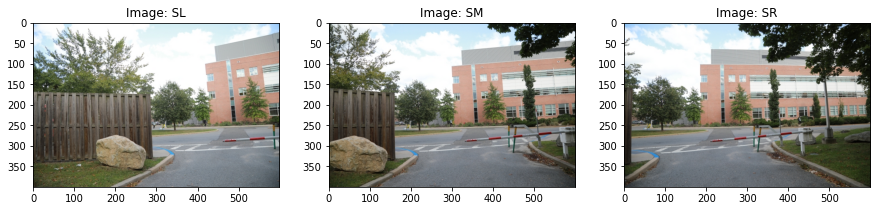

In [ ]:
fig, plot = plt.subplots(1, 3, figsize = (15, 5))

plot[0].imshow(img_sl)
plot[0].set_title("Image: SL")

plot[1].imshow(img_sm)
plot[1].set_title("Image: SM")

plot[2].imshow(img_sr)
plot[2].set_title("Image: SR")

Text(0.5, 1.0, 'Image: PR in PL & PR')

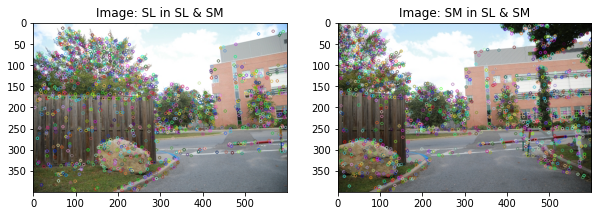

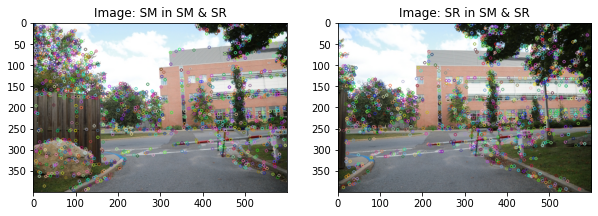

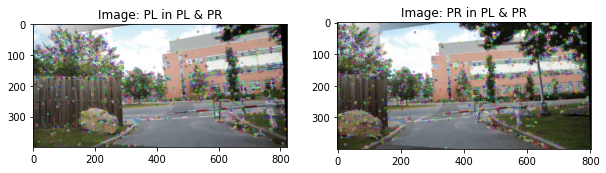

In [ ]:
# Selected Features

sl_in_sl_and_sm, sm_in_sl_and_sm = create_drawn_key_points_image(img_sl, img_sm)
sm_in_sm_and_sr, sr_in_sm_and_sr = create_drawn_key_points_image(img_sm, img_sr)
pl_in_pl_and_pr, pr_in_pl_and_pr = create_drawn_key_points_image(image_sl_sm, image_sm_sr)

fig, plot = plt.subplots(1, 2, figsize = (10, 5))

plot[0].imshow(sl_in_sl_and_sm)
plot[0].set_title("Image: SL in SL & SM")

plot[1].imshow(sm_in_sl_and_sm)
plot[1].set_title("Image: SM in SL & SM")

fig, plot = plt.subplots(1, 2, figsize = (10, 5))

plot[0].imshow(sm_in_sm_and_sr)
plot[0].set_title("Image: SM in SM & SR")

plot[1].imshow(sr_in_sm_and_sr)
plot[1].set_title("Image: SR in SM & SR")

fig, plot = plt.subplots(1, 2, figsize = (10, 5))

plot[0].imshow(pl_in_pl_and_pr)
plot[0].set_title("Image: PL in PL & PR")

plot[1].imshow(pr_in_pl_and_pr)
plot[1].set_title("Image: PR in PL & PR")

Text(0.5, 1.0, 'Image: PL & PR')

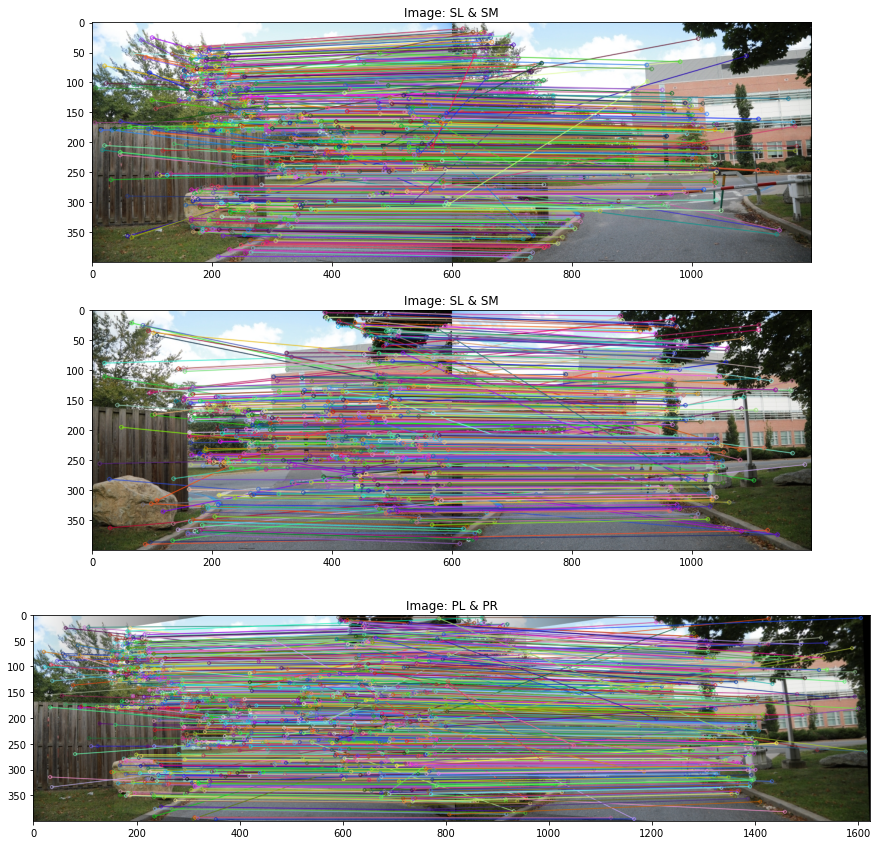

In [ ]:
# Matched Features

sl_and_sm = create_drawn_matched_key_points_image(img_sl, img_sm)
sm_and_sr = create_drawn_matched_key_points_image(img_sm, img_sr)
pl_and_pr = create_drawn_matched_key_points_image(image_sl_sm, image_sm_sr)

fig, plot = plt.subplots(3, 1, figsize = (15, 15))

plot[0].imshow(sl_and_sm)
plot[0].set_title("Image: SL & SM")

plot[1].imshow(sm_and_sr)
plot[1].set_title("Image: SL & SM")

plot[2].imshow(pl_and_pr)
plot[2].set_title("Image: PL & PR")

Text(0.5, 1.0, 'Image: PL & PR')

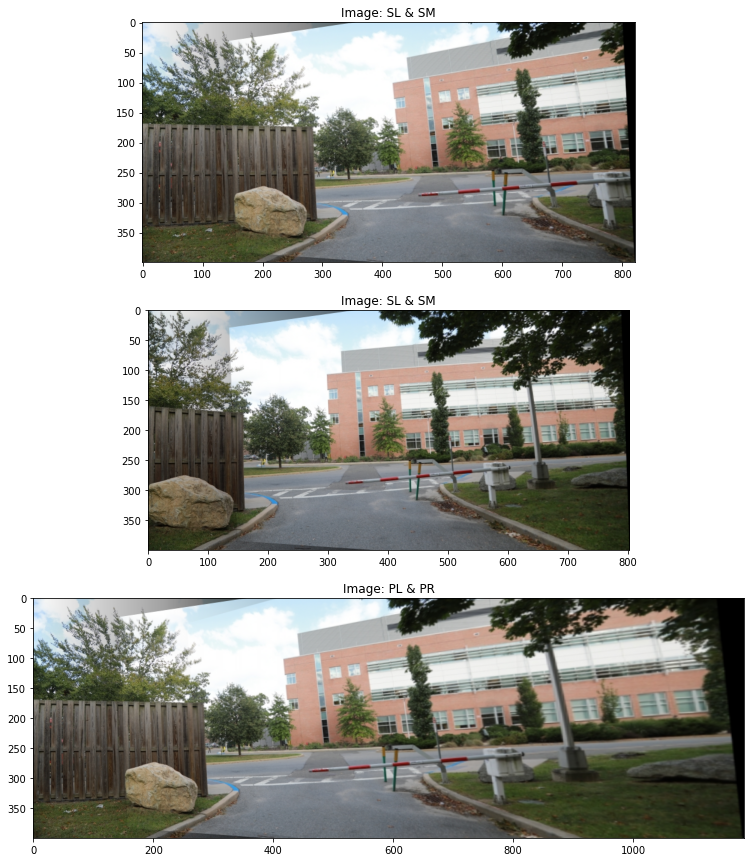

In [ ]:
# Stitched Image

fig, plot = plt.subplots(3, 1, figsize = (15, 15))

plot[0].imshow(image_sl_sm / 255.0)
plot[0].set_title("Image: SL & SM")

plot[1].imshow(image_sm_sr / 255.0)
plot[1].set_title("Image: SL & SM")

plot[2].imshow(image_panorama / 255.0)
plot[2].set_title("Image: PL & PR")

In [ ]:
image_1_2 = get_panorama_result(img_1, img_2)
image_2_3 = get_panorama_result(img_2, img_3)
image_1_2_3 = get_panorama_result(image_1_2, image_2_3)

Text(0.5, 1.0, 'Image: 3')

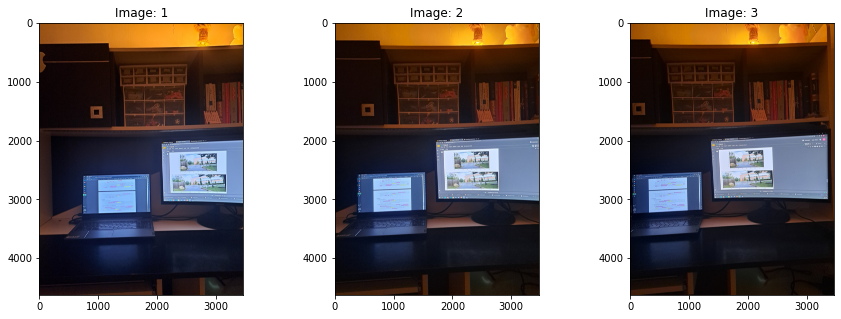

In [ ]:
# Original Images

fig, plot = plt.subplots(1, 3, figsize = (15, 5))

plot[0].imshow(img_1)
plot[0].set_title("Image: 1")

plot[1].imshow(img_2)
plot[1].set_title("Image: 2")

plot[2].imshow(img_3)
plot[2].set_title("Image: 3")

Text(0.5, 1.0, 'Image: 1 & 2 & 3')

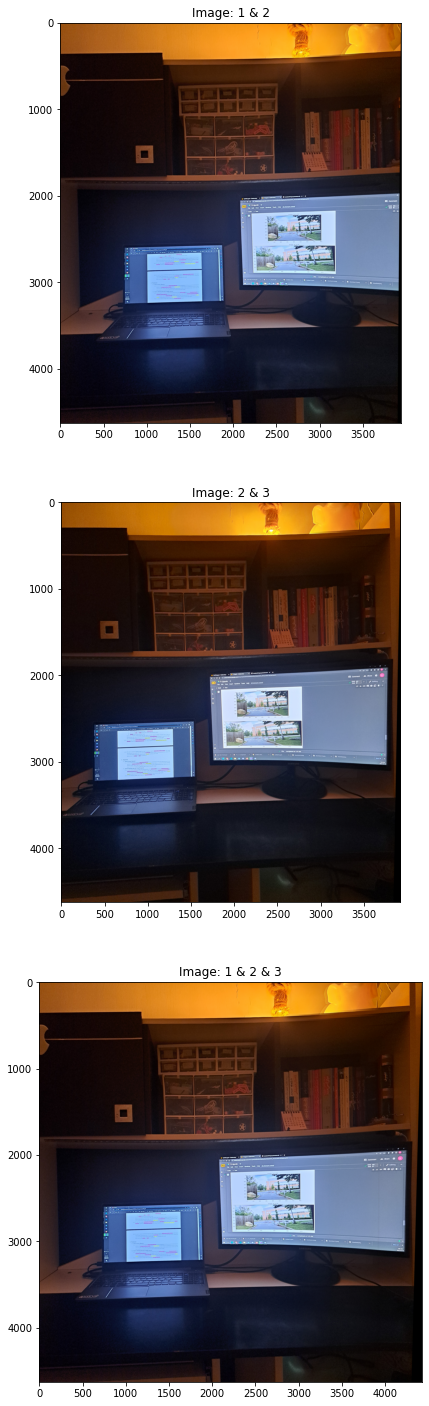

In [ ]:
# Stitched Images

fig, plot = plt.subplots(3, 1, figsize = (10, 25))

plot[0].imshow(image_1_2 / 255.0)
plot[0].set_title("Image: 1 & 2")

plot[1].imshow(image_2_3 / 255.0)
plot[1].set_title("Image: 2 & 3")

plot[2].imshow(image_1_2_3 / 255.0)
plot[2].set_title("Image: 1 & 2 & 3")